In [ ]:
!unzip generator.zip

In [1]:
!pip install nbformat

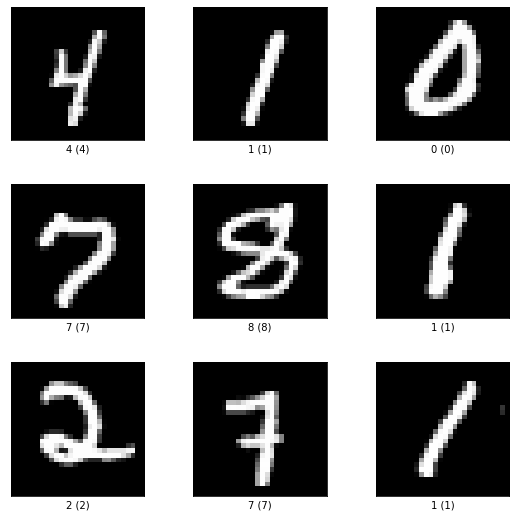

In [21]:
import tensorflow_datasets as tfds

mnist, info = tfds.load("mnist", split="train", with_info=True)

fig = tfds.show_examples(mnist, info)

In [22]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data['image']
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    label = tf.one_hot(data["label"], 10)
    return image, label


In [23]:
gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

In [24]:
import plotly.express as px

img, label = next(iter(cgan_datasets))  
print(label[0])
print("img min/max :", img.numpy().min(), img.numpy().max())
fig = px.imshow(img.numpy()[0,...,0], binary_string=True)
fig.show()

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
img min/max : -1.0 1.0


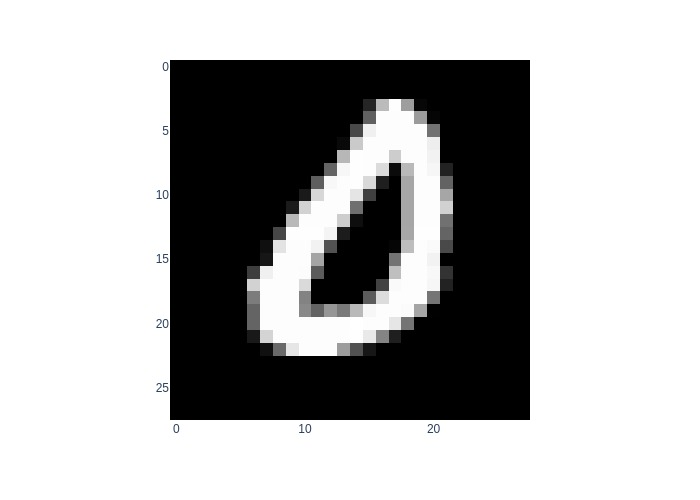

In [25]:
from IPython.display import Image
Image(fig.to_image(format='jpeg'))

In [26]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')
        self.reshape = layers.Reshape((28,28,1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

In [27]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN,self).__init__()
        
        self.dense_z = layers.Dense(256,activation='relu')
        self.dense_y = layers.Dense(256,activation='relu')
        self.combined_dense = layers.Dense(512,activation='relu')
        self.final_dense = layers.Dense(28*28*1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))
    
    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise,label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

In [28]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(layers.Dense(f, activation=None if f==1 else "relu"))
    
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

In [29]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout,self).__init__()
        self.dense = layers.Dense(units*pieces, activation='relu')
        self.dropout = layers.Dropout(.5)
        self.reshape = layers.Reshape((-1, pieces, units))
        
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

In [30]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN,self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        self.dense = layers.Dense(1, activation=None)
        
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

In [31]:
from tensorflow.keras import optimizers,losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

In [32]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [33]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:1.9338608980178833, D:0.17891919612884521
[1/10 EPOCHS, 200 ITER] G:2.505077600479126, D:0.11201618611812592
[1/10 EPOCHS, 300 ITER] G:2.3333754539489746, D:0.17878694832324982
[1/10 EPOCHS, 400 ITER] G:3.060133457183838, D:0.10714658349752426
[2/10 EPOCHS, 100 ITER] G:4.686441898345947, D:0.028507795184850693
[2/10 EPOCHS, 200 ITER] G:2.70424747467041, D:0.3004720211029053
[2/10 EPOCHS, 300 ITER] G:2.9577136039733887, D:0.314066082239151
[2/10 EPOCHS, 400 ITER] G:4.2522358894348145, D:0.030910905450582504
[3/10 EPOCHS, 100 ITER] G:2.1625967025756836, D:0.31236961483955383
[3/10 EPOCHS, 200 ITER] G:3.2051873207092285, D:0.16893905401229858
[3/10 EPOCHS, 300 ITER] G:4.190336227416992, D:0.1789739429950714
[3/10 EPOCHS, 400 ITER] G:3.1386003494262695, D:0.09284945577383041
[4/10 EPOCHS, 100 ITER] G:3.650087833404541, D:0.10548947751522064
[4/10 EPOCHS, 200 ITER] G:3.589350461959839, D:0.1493711620569229
[4/10 EPOCHS, 300 ITER] G:5.0677056312561035, D:0.035031445

In [34]:
import numpy as np
import plotly.graph_objects as go

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())


In [37]:
fig= px.imshow(output,binary_string=True,facet_col=0,facet_col_wrap=5,width=500, height=500,facet_col_spacing=0,facet_row_spacing=0)

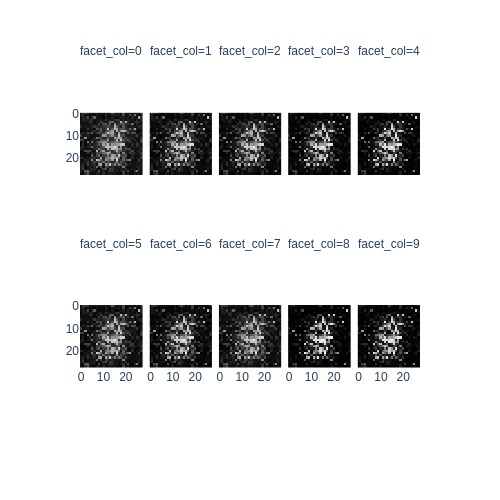

In [38]:
Image(fig.to_image(format='jpeg'))

In [39]:
!unzip /content/generator.zip

Archive:  /content/generator.zip
   creating: conditional_generation/
   creating: conditional_generation/cgan/
 extracting: conditional_generation/cgan/CGAN_500.zip  
  inflating: conditional_generation/cgan/CGAN_500.data-00001-of-00002  
  inflating: conditional_generation/cgan/CGAN_500.index  
  inflating: conditional_generation/cgan/CGAN_500.data-00000-of-00002  
   creating: conditional_generation/data/
 extracting: conditional_generation/data/sketch2pokemon.zip  
   creating: conditional_generation/data/pokemon_pix2pix_dataset/
   creating: conditional_generation/data/pokemon_pix2pix_dataset/train/
  inflating: conditional_generation/data/pokemon_pix2pix_dataset/train/159.jpg  
  inflating: conditional_generation/data/pokemon_pix2pix_dataset/train/155.jpg  
  inflating: conditional_generation/data/pokemon_pix2pix_dataset/train/741.jpg  
  inflating: conditional_generation/data/pokemon_pix2pix_dataset/train/329.jpg  
  inflating: conditional_generation/data/pokemon_pix2pix_dataset

In [40]:
import os
weight_path = '/content/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100])

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())



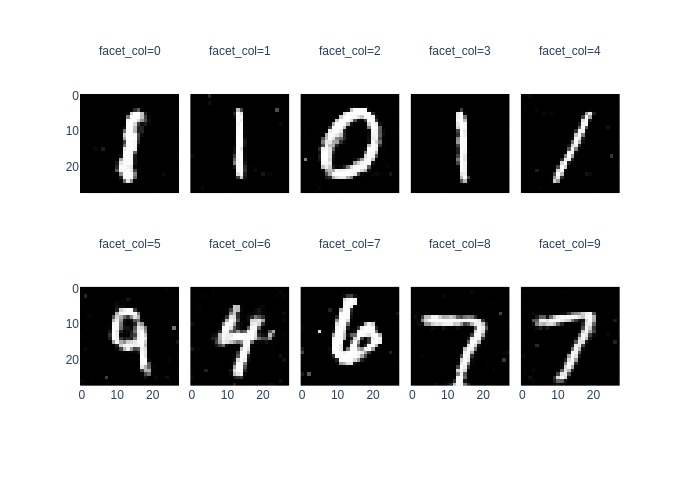

In [41]:
fig = px.imshow(output, facet_col=0, facet_col_wrap=5,binary_string=True)
Image(fig.to_image(format='jpeg'))

In [42]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.221650123596191, D:0.005615453235805035
[1/1 EPOCHS, 199 ITER] G:5.014835357666016, D:0.021401286125183105
[1/1 EPOCHS, 299 ITER] G:4.692233085632324, D:0.02837521582841873
[1/1 EPOCHS, 399 ITER] G:6.395900726318359, D:0.007520932704210281


In [43]:
number = 10

weight_path = '/content/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

In [44]:
label = tf.one_hot(10,10)
label = tf.expand_dims(label,axis=0)
label = tf.repeat(label, 10, axis=0)

In [45]:
generator = GeneratorCGAN()
generator.load_weights(weight_path)

In [46]:
output = generator(noise, label)
output = np.squeeze(output.numpy())

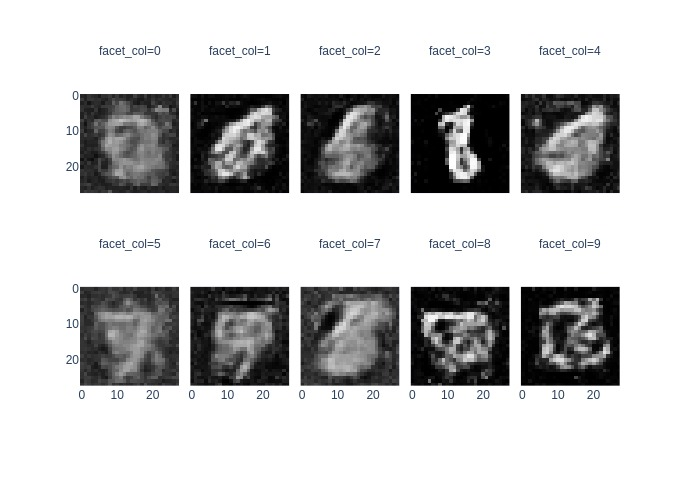

In [47]:
fig = px.imshow(output, facet_col=0, facet_col_wrap=5,binary_string=True)
Image(fig.to_image(format='jpeg'))

In [48]:
import os
data_path = '/content/conditional_generation/data/pokemon_pix2pix_dataset/train/'
img_files = tf.io.gfile.glob(data_path+'*.jpg')

In [49]:
file_ds = tf.data.Dataset.from_tensor_slices(img_files)

In [50]:
def change_img(path):
    raw_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(raw_img)
    conv_img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    return conv_img
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
img_files

In [52]:
train_ds = file_ds.map(change_img, num_parallel_calls=AUTOTUNE)

In [53]:
next(iter(train_ds)).shape

TensorShape([256, 512, 3])

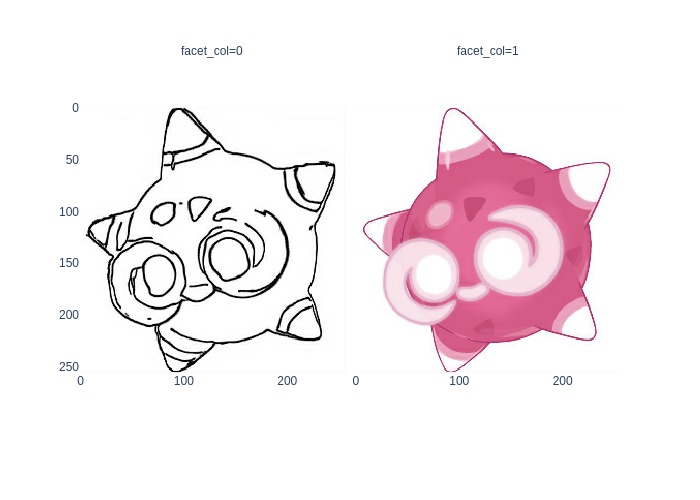

In [55]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) -1

def denormalize(x):
    x = (x+1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :]
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

fig = px.imshow(np.array([denormalize(sketch),denormalize(colored)]),facet_col=0)
Image(fig.to_image(format='jpeg'))

In [56]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


In [57]:
sket_df = {}
col_df = {}
for i in range(10):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    sket_df[i] = augmented_sketch
    col_df[i] = augmented_colored

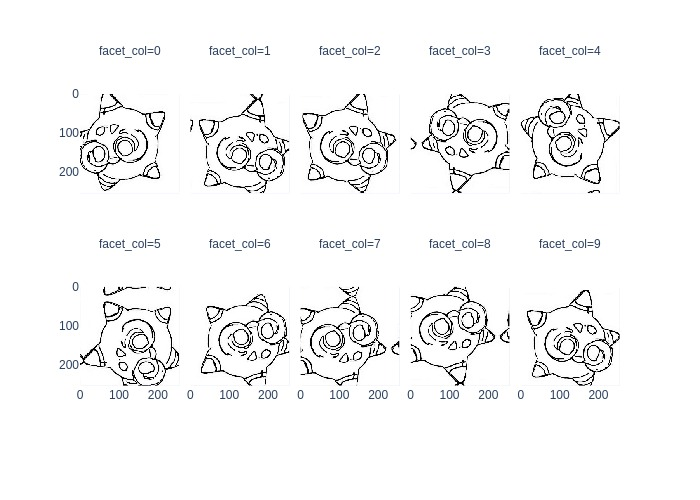

In [58]:
fig = px.imshow(np.array(list(sket_df.values())),facet_col=0,facet_col_wrap=5)
Image(fig.to_image(format='jpeg'))

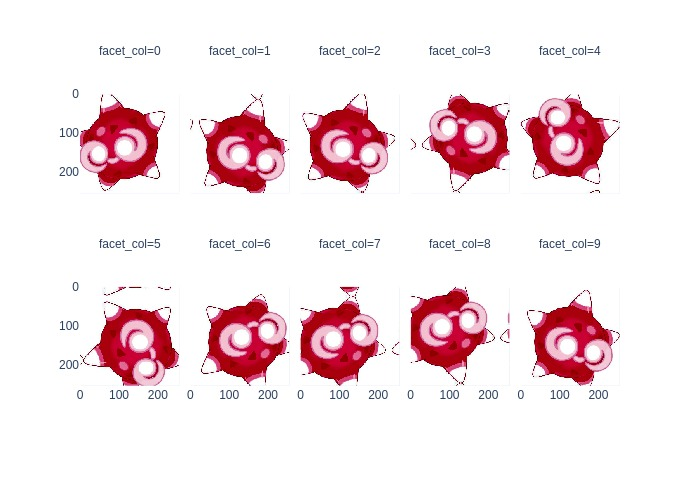

In [59]:
fig = px.imshow(np.array(list(col_df.values())),facet_col=0,facet_col_wrap=5)
Image(fig.to_image(format='jpeg'))

In [60]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

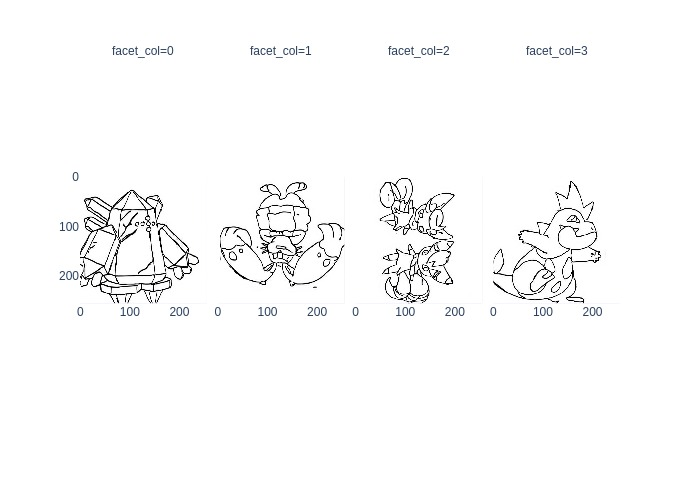

In [61]:
fig = px.imshow(sketch, facet_col=0,facet_col_wrap=4)
Image(fig.to_image(format='jpeg'))

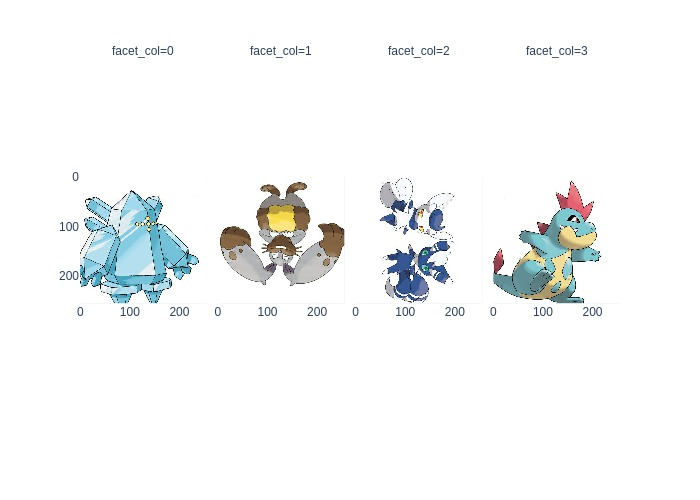

In [62]:
fig = px.imshow(colored, facet_col=0, facet_col_wrap=4)
Image(fig.to_image(format='jpeg'))

In [63]:
import os

data_path = '/content/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


In [64]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [65]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [66]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

In [67]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock,self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks=[]
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [68]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

In [69]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [70]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [71]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks=[]
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks=[]
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [72]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

In [73]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
    
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
        
        if self.use_bn:
            x = self.batchnorm(x)
        
        if self.act:
            x = self.lrelu(x)
        return x

In [74]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [75]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [76]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

In [77]:
import tensorflow as tf
import matplotlib.pyplot as plt
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)

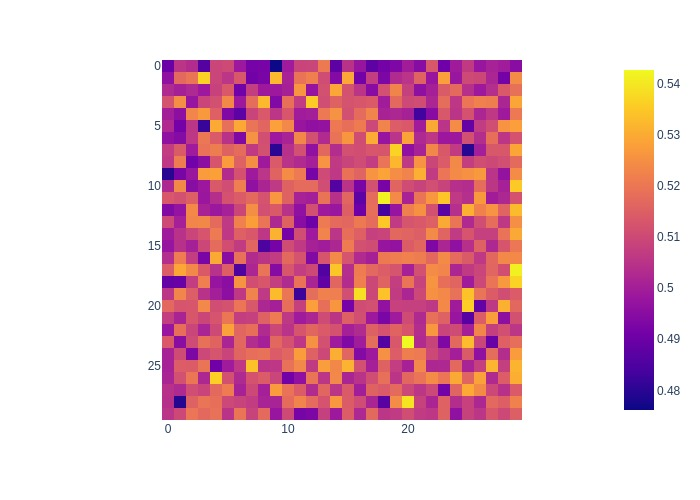

In [78]:
fig = px.imshow(disc_out[0,...,0])
Image(fig.to_image(format='jpeg'))

In [79]:
from tensorflow.keras import losses
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc),real_disc)

In [80]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

논문상 제너레이터의 손실  
![image.png](attachment:image.png)

In [81]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [82]:
EPOCHS = 1

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9354                     
L1_loss:0.4677                     
Discriminator_loss:1.1569

EPOCH[1] - STEP[20]                     
Generator_loss:1.0781                     
L1_loss:0.3282                     
Discriminator_loss:1.3027

EPOCH[1] - STEP[30]                     
Generator_loss:0.8052                     
L1_loss:0.2767                     
Discriminator_loss:1.3333

EPOCH[1] - STEP[40]                     
Generator_loss:0.9105                     
L1_loss:0.2283                     
Discriminator_loss:1.1835

EPOCH[1] - STEP[50]                     
Generator_loss:1.5073                     
L1_loss:0.2876                     
Discriminator_loss:1.0901

EPOCH[1] - STEP[60]                     
Generator_loss:1.7111                     
L1_loss:0.2138                     
Discriminator_loss:0.9591

EPOCH[1] - STEP[70]                     
Generator_loss:2.0879                     
L1_loss:0.2670                    

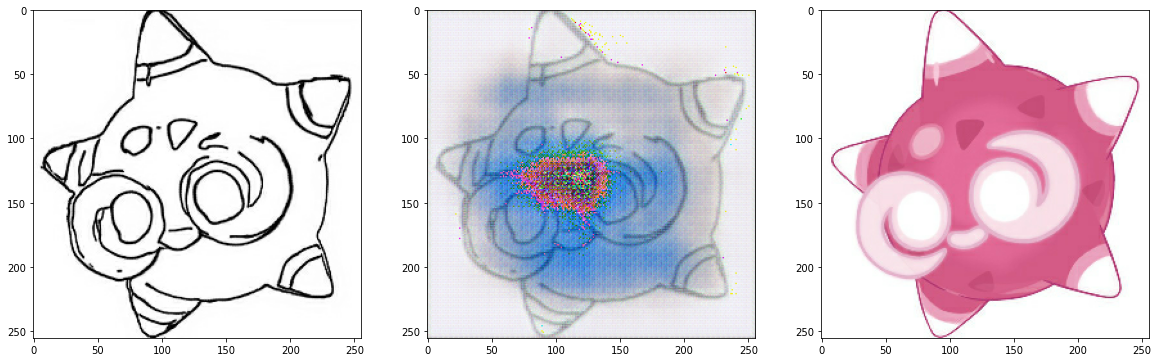

In [83]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

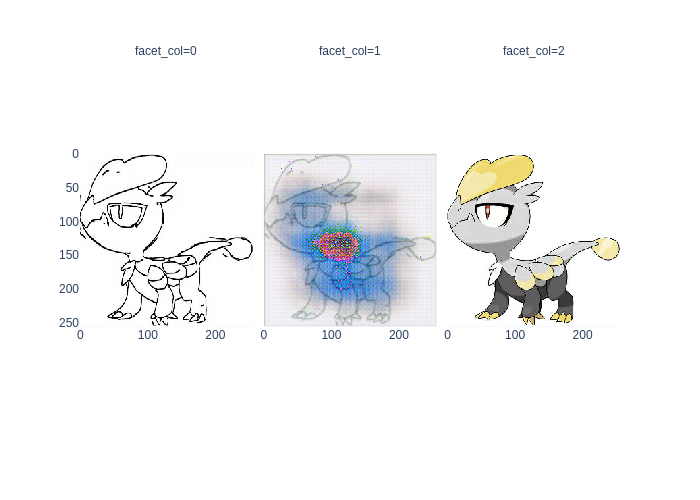

In [86]:
test_ind = 5

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)
fig = px.imshow(np.array([denormalize(sketch),pred[0],denormalize(colored)]),facet_col=0)
Image(fig.to_image(format='png'))

In [87]:
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip

--2022-03-15 07:49:11--  https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 54.192.19.225, 54.192.19.5, 54.192.19.169, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|54.192.19.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30179339 (29M) [application/zip]
Saving to: ‘cityscapes.zip.1’

cityscapes.zip.1    100%[===================>]  28.78M  37.9MB/s    in 0.8s    

2022-03-15 07:49:12 (37.9 MB/s) - ‘cityscapes.zip.1’ saved [30179339/30179339]



In [88]:
!unzip /content/cityscapes.zip

Archive:  /content/cityscapes.zip
replace cityscapes/train/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [89]:
data_path = "/content/cityscapes/train/"

In [90]:
ds_files = tf.data.Dataset.list_files(data_path+"*")

In [91]:
raw_img = tf.io.read_file(next(iter(ds_files)))

In [92]:
decoded_img = tf.io.decode_image(raw_img,dtype=tf.float32)

In [93]:
w = decoded_img.shape[1] // 2

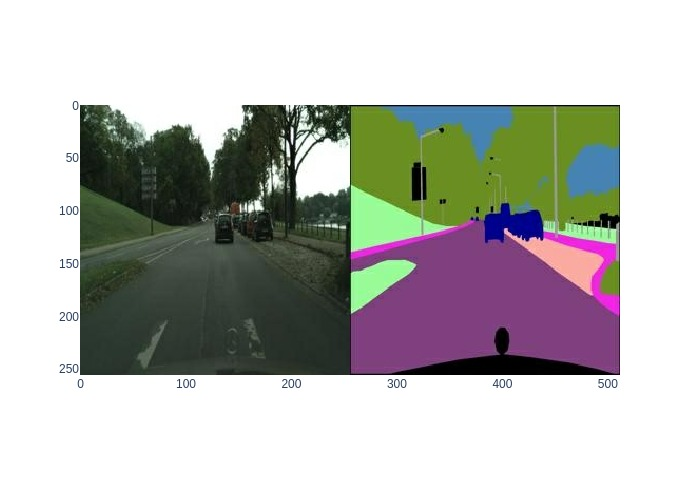

In [102]:
fig = px.imshow(decoded_img)
Image(fig.to_image(format='jpeg'))

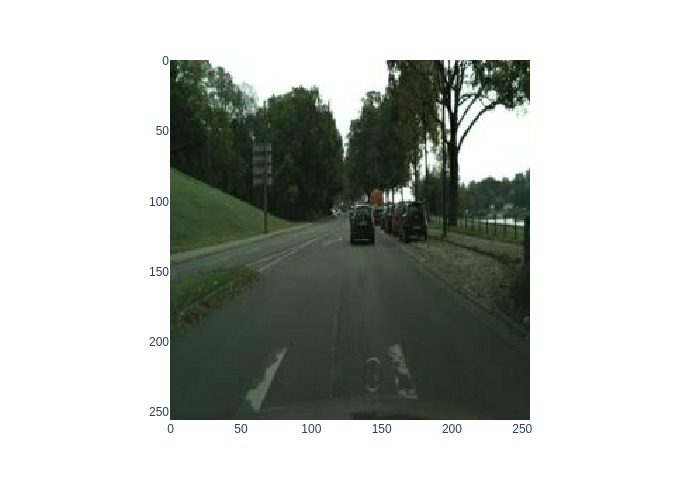

In [103]:
fig = px.imshow(decoded_img[:,:w,:])
Image(fig.to_image(format='jpeg'))

In [96]:
train_images = ds_files.map(get_train).shuffle(100).batch(4)

In [97]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())

In [98]:
sket, col = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

In [99]:
sket.shape

(4, 256, 256, 3)

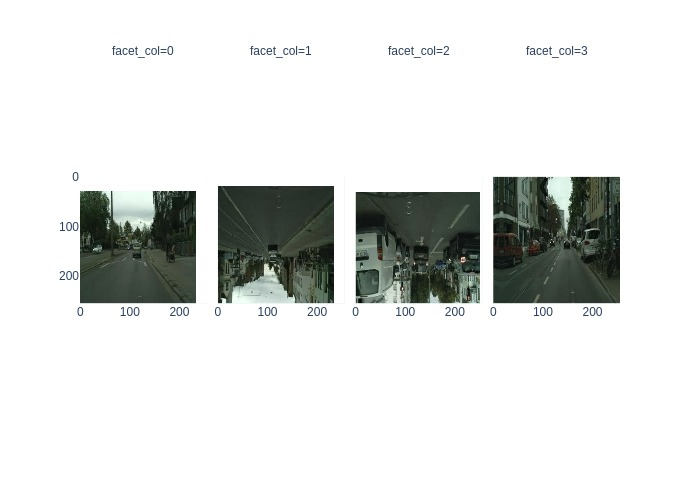

In [104]:
fig = px.imshow(sket,facet_col=0)
Image(fig.to_image(format='jpeg'))

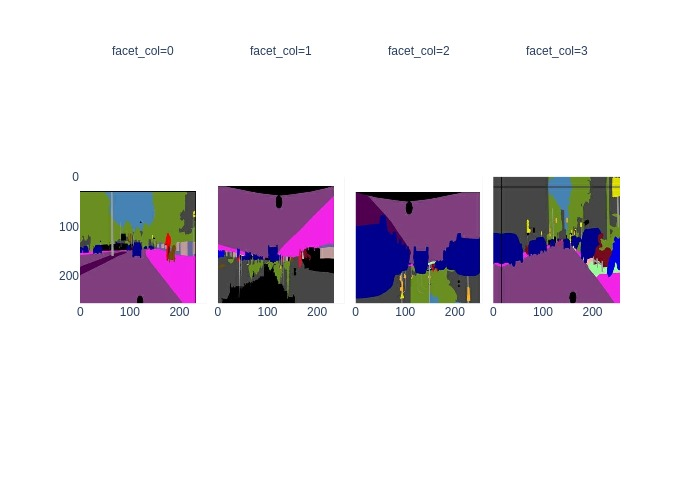

In [105]:
fig = px.imshow(col,facet_col=0)
Image(fig.to_image(format='jpeg'))

In [106]:
EPOCHS = 1

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(colored, sketch)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9525                     
L1_loss:0.2785                     
Discriminator_loss:0.9395

EPOCH[1] - STEP[20]                     
Generator_loss:1.3407                     
L1_loss:0.2418                     
Discriminator_loss:1.1241

EPOCH[1] - STEP[30]                     
Generator_loss:2.0044                     
L1_loss:0.1945                     
Discriminator_loss:1.3819

EPOCH[1] - STEP[40]                     
Generator_loss:1.1734                     
L1_loss:0.2247                     
Discriminator_loss:1.3063

EPOCH[1] - STEP[50]                     
Generator_loss:1.5252                     
L1_loss:0.2249                     
Discriminator_loss:0.7724

EPOCH[1] - STEP[60]                     
Generator_loss:1.6652                     
L1_loss:0.1820                     
Discriminator_loss:0.8040

EPOCH[1] - STEP[70]                     
Generator_loss:1.6887                     
L1_loss:0.1694                    

In [107]:
f_name = data_path + os.listdir(data_path)[5]
col,sket = load_img(f_name)
col,sket = denormalize(col),denormalize(sket)

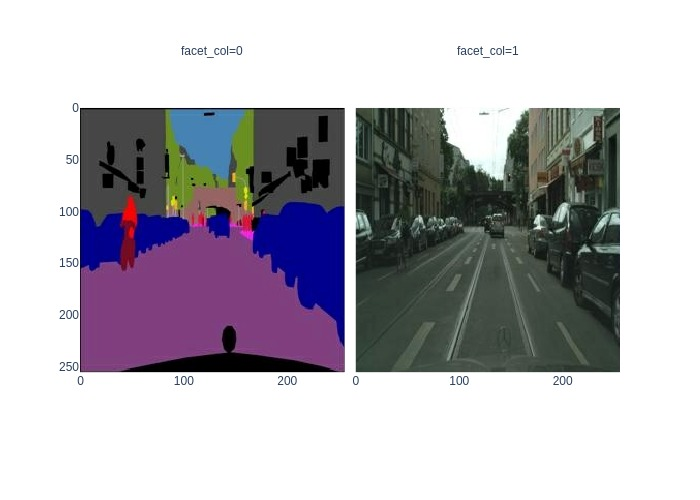

In [108]:
fig = px.imshow(np.array([sket,col]),facet_col=0)
Image(fig.to_image(format='jpeg'))

In [109]:
EPOCHS = 1

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (col, sket) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sket,col)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0300                     
L1_loss:0.2230                     
Discriminator_loss:0.5819

EPOCH[1] - STEP[20]                     
Generator_loss:0.6131                     
L1_loss:0.1687                     
Discriminator_loss:1.1657

EPOCH[1] - STEP[30]                     
Generator_loss:1.1925                     
L1_loss:0.1842                     
Discriminator_loss:0.9486

EPOCH[1] - STEP[40]                     
Generator_loss:1.2337                     
L1_loss:0.2014                     
Discriminator_loss:0.4699

EPOCH[1] - STEP[50]                     
Generator_loss:1.3821                     
L1_loss:0.1614                     
Discriminator_loss:0.7583

EPOCH[1] - STEP[60]                     
Generator_loss:1.0392                     
L1_loss:0.1900                     
Discriminator_loss:0.7414

EPOCH[1] - STEP[70]                     
Generator_loss:0.9930                     
L1_loss:0.2061                    

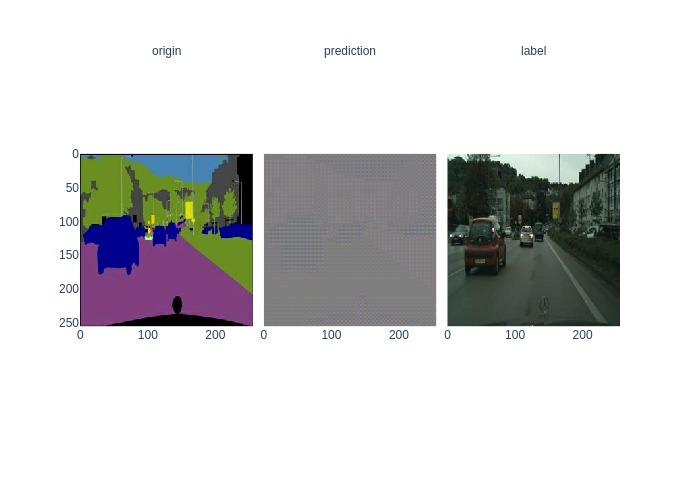

In [110]:
test_ind = 0

f = data_path + os.listdir(data_path)[test_ind]
col, sket = load_img(f)

pred = generator(tf.expand_dims(sket, 0))
pred = denormalize(pred)
fig = px.imshow(np.array([denormalize(sket),pred[0],denormalize(col)]),facet_col=0)
fig.layout.annotations[0]['text'] = "origin"
fig.layout.annotations[1]['text'] = "prediction"
fig.layout.annotations[2]['text'] = "label"
Image(fig.to_image(format='jpeg'))

In [111]:
EPOCHS = 1

# generator = UNetGenerator()
# discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (col, sket) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sket,col)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.6876                     
L1_loss:0.1763                     
Discriminator_loss:1.1966

EPOCH[1] - STEP[20]                     
Generator_loss:1.5181                     
L1_loss:0.1976                     
Discriminator_loss:0.4673

EPOCH[1] - STEP[30]                     
Generator_loss:3.2109                     
L1_loss:0.1823                     
Discriminator_loss:1.1427

EPOCH[1] - STEP[40]                     
Generator_loss:3.0279                     
L1_loss:0.1564                     
Discriminator_loss:1.2253

EPOCH[1] - STEP[50]                     
Generator_loss:1.0818                     
L1_loss:0.2187                     
Discriminator_loss:0.6370

EPOCH[1] - STEP[60]                     
Generator_loss:0.9231                     
L1_loss:0.2011                     
Discriminator_loss:1.2731

EPOCH[1] - STEP[70]                     
Generator_loss:1.5367                     
L1_loss:0.1760                    

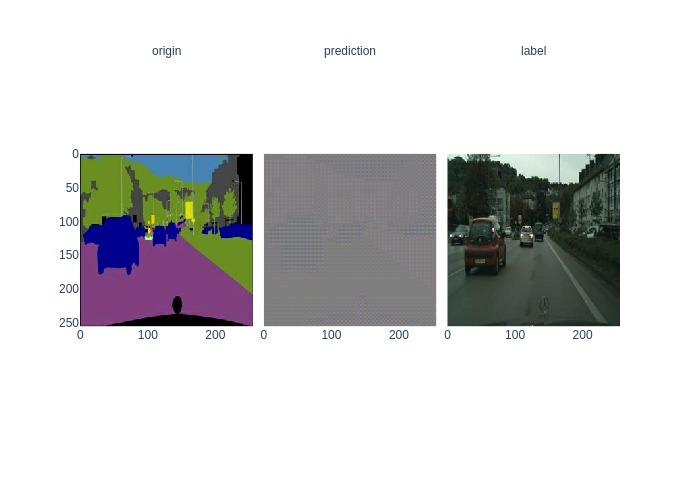

In [112]:
test_ind = 0

f = data_path + os.listdir(data_path)[test_ind]
col, sket = load_img(f)

pred = generator(tf.expand_dims(sket, 0))
pred = denormalize(pred)
fig = px.imshow(np.array([denormalize(sket),pred[0],denormalize(col)]),facet_col=0)
fig.layout.annotations[0]['text'] = "origin"
fig.layout.annotations[1]['text'] = "prediction"
fig.layout.annotations[2]['text'] = "label"
Image(fig.to_image(format='jpeg'))

EPOCH[1] - STEP[10]                     
Generator_loss:1.4188                     
L1_loss:0.1811                     
Discriminator_loss:0.5633

EPOCH[1] - STEP[20]                     
Generator_loss:1.2511                     
L1_loss:0.2077                     
Discriminator_loss:0.8967

EPOCH[1] - STEP[30]                     
Generator_loss:1.6168                     
L1_loss:0.1578                     
Discriminator_loss:1.0328

EPOCH[1] - STEP[40]                     
Generator_loss:1.3608                     
L1_loss:0.1881                     
Discriminator_loss:0.9675

EPOCH[1] - STEP[50]                     
Generator_loss:1.4119                     
L1_loss:0.1597                     
Discriminator_loss:0.7194

EPOCH[1] - STEP[60]                     
Generator_loss:1.6366                     
L1_loss:0.2003                     
Discriminator_loss:0.5530

EPOCH[1] - STEP[70]                     
Generator_loss:1.9625                     
L1_loss:0.2244                    

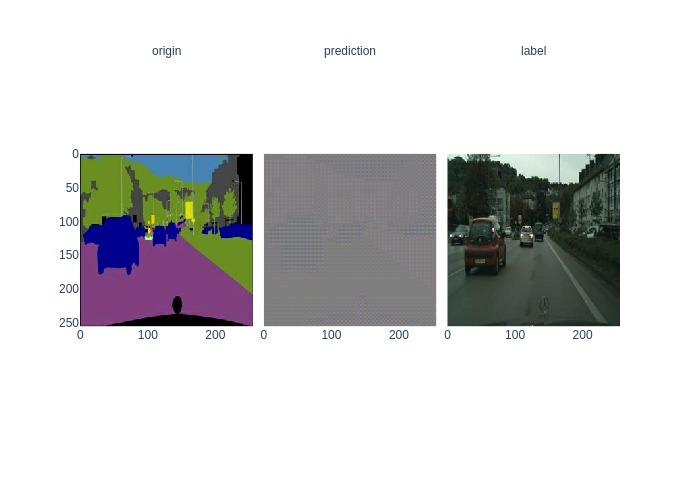

In [114]:
EPOCHS = 1

# generator = UNetGenerator()
# discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (col, sket) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sket,col)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

test_ind = 0

f = data_path + os.listdir(data_path)[test_ind]
col, sket = load_img(f)

pred = generator(tf.expand_dims(sket, 0))
pred = denormalize(pred)
fig = px.imshow(np.array([denormalize(sket),pred[0],denormalize(col)]),facet_col=0)
fig.layout.annotations[0]['text'] = "origin"
fig.layout.annotations[1]['text'] = "prediction"
fig.layout.annotations[2]['text'] = "label"
Image(fig.to_image(format='jpeg'))

EPOCH[1] - STEP[10]                     
Generator_loss:1.0974                     
L1_loss:0.1699                     
Discriminator_loss:1.0675

EPOCH[1] - STEP[20]                     
Generator_loss:1.4201                     
L1_loss:0.1854                     
Discriminator_loss:0.4800

EPOCH[1] - STEP[30]                     
Generator_loss:2.2744                     
L1_loss:0.1993                     
Discriminator_loss:0.5684

EPOCH[1] - STEP[40]                     
Generator_loss:2.3335                     
L1_loss:0.2113                     
Discriminator_loss:1.0883

EPOCH[1] - STEP[50]                     
Generator_loss:1.4658                     
L1_loss:0.1933                     
Discriminator_loss:0.3830

EPOCH[1] - STEP[60]                     
Generator_loss:0.6855                     
L1_loss:0.1716                     
Discriminator_loss:1.5654

EPOCH[1] - STEP[70]                     
Generator_loss:1.0300                     
L1_loss:0.1733                    

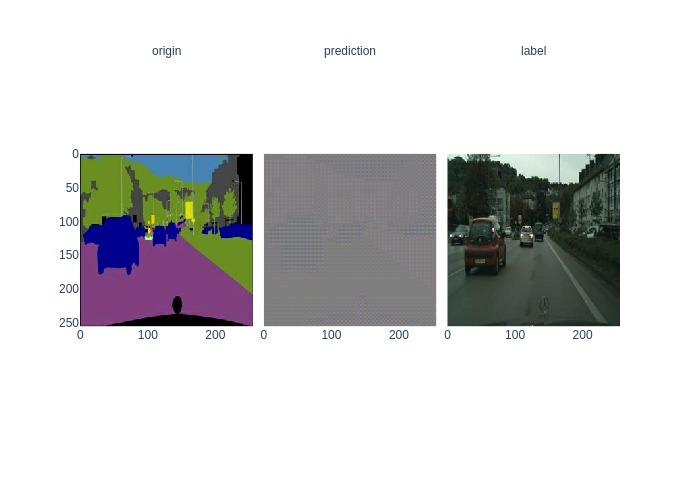

In [115]:
EPOCHS = 1

# generator = UNetGenerator()
# discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (col, sket) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sket,col)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

test_ind = 0

f = data_path + os.listdir(data_path)[test_ind]
col, sket = load_img(f)

pred = generator(tf.expand_dims(sket, 0))
pred = denormalize(pred)
fig = px.imshow(np.array([denormalize(sket),pred[0],denormalize(col)]),facet_col=0)
fig.layout.annotations[0]['text'] = "origin"
fig.layout.annotations[1]['text'] = "prediction"
fig.layout.annotations[2]['text'] = "label"
Image(fig.to_image(format='jpeg'))

# 실험종료

GAN에 대한 이해가 부족한 것인지.. 알 수가 없다  
이전 포켓몬 스케치에는 어느정도 적용이 되었으나, 거리 사진에는 도통
먹혀들지를 않는다
epoch도 100회 이상을 시도했지만 효과가 아예 없어 다른 교육에 영향을 받지 않기 위해서 여기서 종료  
이번에 시각화 툴에서 plotly를 시도했었는데 사용하기 편하게 색상이 이쁘긴 하나, 문제점을 식별했다  
원래 reactive하게 시각화 하기 때문에 이미지와는 다른 형식으로 움직이기 떄문에, colab에 정상적으로 저장이 안되는 것이었다  
이를 위해서 Ipython으로 다시 덮어주는 작업을 해주었는데 이 과정에서 이전 에포크의 기록이 다 날라가버렸다  
그래서 여기 노트북에는 이미지를 시각화 해두고, 이전 결과가 남아있는 다른 노트북을 추가로 커밋하여 기록을 남겨두고자 한다